# Image Classification - ResNet (WIP)

This notebook evaluates the Residual neural network (ResNet) on CIFAR-100 dataset. <br>
ResNet adds skip connections to the CNN model to learn identity.

This is just a simple ResNet for testing.

## Load, Visualize, Prepare Data

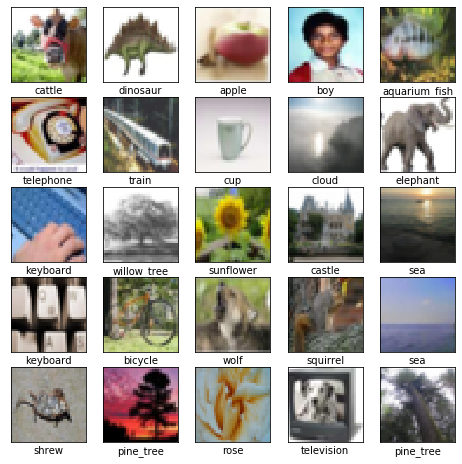

In [2]:
import numpy as np
import scipy
import keras
import tensorflow as tf
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import skimage
import skimage.transform

category_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 
                  'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 
                  'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 
                  'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
                  'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 
                  'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 
                  'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 
                  'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
                  'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
                  'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 
                  'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
num_categories = len(category_names)

# Get the training and test data from datasets
# x_train are training images : shape(50000, 32, 32, 3)
# y_train are the training labels : shape(50000, 1)
# x_test are test images : shape(10000, 32, 32, 3)
# y_test are the test labels : shape(10000, 1) 
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

y_train = keras.utils.to_categorical(y_train, num_categories) # replace element from [[2], ... ] to [[0 0 1 0 0 0 0 0 0 0], ...]
y_test = keras.utils.to_categorical(y_test, num_categories) # replace element from [[2], ... ] to [[0 0 1 0 0 0 0 0 0 0], ...]

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    index = np.argmax(y_train[i]) # reverse keras.utils.to_categorical
    plt.xlabel(category_names[index])
plt.show()

# Prepare Data
x_train = x_train / 255.0
x_test = x_test / 255.0

## ResNet Model

In [3]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, AveragePooling2D 
from keras.losses import CategoricalCrossentropy
from keras.initializers import glorot_uniform
from keras.optimizers import Adam 

def identity_block(X, filters):
    '''
    Identity block : input and output have same size
    '''
    X_shortcut = X
    
    # Add two convolution layers
    X = Conv2D(filters[0], kernel_size=(3, 3), strides = (1,1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters[1], kernel_size=(1, 1), strides = (1,1), padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    
    # Add shortcut before the final activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

def conv_block(X, filters):
    '''
    Convolution block : similar to identity block but half the dimension
    '''
    X_shortcut = X
    
    # Add two convolution layers
    X = Conv2D(filters[0], kernel_size=(3, 3), strides = (2,2), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters[1], kernel_size=(1, 1), strides = (1,1), padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    
    # Convolution shortcut
    X_shortcut = Conv2D(filters[1], kernel_size=(1, 1), strides = (2,2), padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    # Add shortcut before the final activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

X_input = Input(x_train.shape[1:])

X = conv_block(X_input, [32, 32])
X = identity_block(X, [32, 32])

X = conv_block(X, [64, 64])
X = identity_block(X, [64, 64])

X = conv_block(X, [128, 128])
X = identity_block(X, [128, 128])

X = conv_block(X, [256, 256])
X = identity_block(X, [256, 256])

X = AveragePooling2D(pool_size=(2,2), padding = 'valid')(X)
X = Flatten()(X)
X = Dense(256, activation='relu')(X)
X = Dense(128, activation='relu')(X)
X = Dense(num_categories, activation='softmax')(X)

resnet_model = Model(inputs = X_input, outputs = X)

optimizer = Adam(learning_rate=0.0001)
resnet_model.compile(optimizer=optimizer, 
                     loss=CategoricalCrossentropy(from_logits=True), 
                     metrics=['accuracy'])
#resnet_model.summary()

## Training and Prediction

In [ ]:
model = resnet_model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=25, batch_size=50, shuffle=True, verbose =1)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
y_prediction = model.predict(x_test[0:25])
y_prediction_category_id = np.argmax(y_prediction, axis=1) # reverse keras.utils.to_categorical

## Evaluation metrics


 Test accuracy: 0.13580000400543213


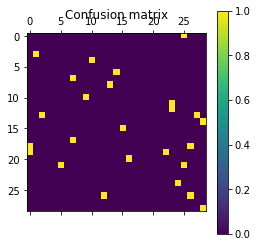


 Plot metrics: ['val_loss', 'val_accuracy', 'loss', 'accuracy']


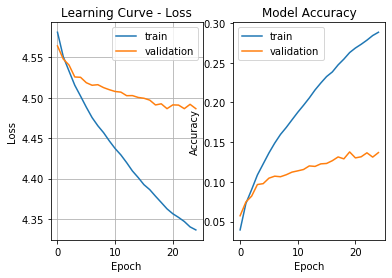

In [6]:
import sklearn.metrics as metrics
print('\n Test accuracy:', test_acc)

# show confusion matrix
y_test_category_id = np.argmax(y_test[0:25], axis=1)
confusion_matrix = metrics.confusion_matrix(y_test_category_id, y_prediction_category_id)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()

print('\n Plot metrics:', list(history.history.keys()))
# show history for loss
plt.subplot(1,2,1)
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
# show history for accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

## References
**ResNet** : He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image recognition." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 770-778. 2016. <br/>
**ResNeXt**. Xie, Saining, Ross Girshick, Piotr Dollár, Zhuowen Tu, and Kaiming He. "Aggregated residual transformations for deep neural networks." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 1492-1500. 2017.